In [18]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
import os

load_dotenv()

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=os.getenv("GOOGLE_API_KEY"),
    temperature=0.7,
)

In [19]:
from __future__ import annotations

import operator
from typing import TypedDict, List, Annotated

from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

from langchain_core.messages import SystemMessage, HumanMessage

In [20]:
class Task(BaseModel):
    id: int
    title: str
    brief: str = Field(..., description="What to cover")

In [21]:
class Plan(BaseModel):
    blog_title: str
    tasks: List[Task]


In [22]:
class State(TypedDict):
    topic: str
    plan: Plan
    # reducer: results from workers get concatenated automatically
    sections: Annotated[List[str], operator.add]
    final: str

In [28]:
def orchestrator(state: State) -> dict:

    plan = llm.with_structured_output(Plan).invoke(
        [
            SystemMessage(
                content=(
                    "Create a blog plan with 3-5 sections on the following topic."
                )
            ),
            HumanMessage(content=f"Topic: {state['topic']}"),
        ]
    )
    return {"plan": plan}


In [24]:
def fanout(state: State):
    return [Send("worker", {"task": task, "topic": state["topic"], "plan": state["plan"]})
            for task in state["plan"].tasks]


In [25]:
def worker(payload: dict) -> dict:

    # payload contains what we sent
    task = payload["task"]
    topic = payload["topic"]
    plan = payload["plan"]

    blog_title = plan.blog_title

    section_md = llm.invoke(
        [
            SystemMessage(content="Write one clean Markdown section."),
            HumanMessage(
                content=(
                    f"Blog: {blog_title}\n"
                    f"Topic: {topic}\n\n"
                    f"Section: {task.title}\n"
                    f"Brief: {task.brief}\n\n"
                    "Return only the section content in Markdown."
                )
            ),
        ]
    ).content.strip()

    return {"sections": [section_md]}


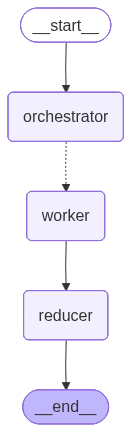

In [26]:
from pathlib import Path

def reducer(state: State) -> dict:
    
    title = state["plan"].blog_title
    body = "\n\n".join(state["sections"]).strip()

    final_md = f"# {title}\n\n{body}\n"

    # ---- save to file ----
    filename = title.lower().replace(" ", "_") + ".md"
    output_path = Path(filename)
    output_path.write_text(final_md, encoding="utf-8")

    return {"final": final_md}
g = StateGraph(State)
g.add_node("orchestrator", orchestrator)
g.add_node("worker", worker)
g.add_node("reducer", reducer)
g.add_edge(START, "orchestrator")
g.add_conditional_edges("orchestrator", fanout, ["worker"])
g.add_edge("worker", "reducer")
g.add_edge("reducer", END)

app = g.compile()

app

In [29]:
out = app.invoke({"topic": "Write a blog on Self Attention", "sections": []})

In [30]:
out

{'topic': 'Write a blog on Self Attention',
 'plan': Plan(blog_title='Self-Attention Explained: How AI Understands Context', tasks=[Task(id=1, title='Introduction to Attention Mechanisms', brief='Introduce the general concept of attention in deep learning, its purpose in helping models focus on relevant parts of input, and set the stage for self-attention as a powerful evolution.'), Task(id=2, title="The 'Self' in Self-Attention: Why It Matters", brief='Explain what distinguishes self-attention from traditional attention mechanisms. Emphasize its ability to relate different positions of a single sequence to each other to compute a representation of the same sequence, highlighting its importance for understanding context and long-range dependencies.'), Task(id=3, title='Deconstructing Self-Attention: Q, K, V in Action', brief='Detail the core mechanics of self-attention. Explain the roles of Query (Q), Key (K), and Value (V) vectors, how they are derived from input embeddings, and the m